# DLC Live PyTorch Demo

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dlclive import DLCLive
from dlclive import Display
import cv2
import numpy as np
from pathlib import Path
import time
from onnxruntime import quantization
import onnx
import onnxruntime as ort
import os
import glob
import ipywidgets as widgets
from IPython.display import display
import torch
from onnxconverter_common import float16
import matplotlib.pyplot as plt
from dlclive.benchmark_pytorch import analyze_video

from deeplabcut.pose_estimation_pytorch.config import read_config_as_dict
from deeplabcut.pose_estimation_pytorch.models import PoseModel


Loading DLC 3.0.0rc4...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


/home/dikra/miniconda3/envs/dlc-live/lib/python3.10/site-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


# Setup

In [9]:
# Define root directory
root = "/media/dikra/PhD/DATA/DLC24_Data/dlc-live-dummy"

In [13]:
projects = [d for d in next(os.walk(root))[1]]
project_selection = widgets.Dropdown(
    options=projects,
    value=projects[0],
    description="Choose a Project!",
    disabled=False,
)
display(project_selection)

Dropdown(description='Choose a Project!', options=('fly-kevin', 'hand-track', 'superbird', 'superbird_ssdlite'…

In [14]:
# Get working directory and read model pytorch config file
working_dir = os.path.join(root, project_selection.value)
model_cfg = read_config_as_dict(Path(working_dir) / "pytorch_config.yaml")

In [15]:
snapshots = glob.glob(os.path.normpath(working_dir + "/*.pt*"))
snapshots = [s.split("/")[-1] for s in snapshots]
snapshot_selection = widgets.Dropdown(
    options=snapshots,
    value=snapshots[0],
    description="Choose your snapshot!",
    disabled=False,
)
display(snapshot_selection)

Dropdown(description='Choose your snapshot!', options=('snapshot-263.pt',), value='snapshot-263.pt')

# Model exporting

### PyTorch to ONNX

In [24]:
# Replace with your onnx model name
onnx_model_name = "resnet" 
onnx_model_path = os.path.join(working_dir, str(onnx_model_name + ".onnx"))

In [19]:
# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"

snapshot_path = os.path.join(working_dir, snapshot_selection.value)
# Create pretrained DLC3 PoseModel from snapshot  
model = PoseModel.build(model_cfg["model"])
weights = torch.load(snapshot_path, map_location=device)
model.load_state_dict(weights["model"])

# Random dummy input
dummy_input = torch.zeros((1, 3, 658, 302))

# Export PyTorch model to ONNX
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    verbose=False,
    input_names=["input"],
    dynamic_axes={"input": {0: "batch_size", 2: "height", 3: "width"}},
)
#* Note: batch_size, height, and width dimensions are dynamic, 
#* i.e. the onnx model can take different batch sizes, heights and width

/tmp/ipykernel_4853/2922966602.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(snapshot_path, map_location=device)


### ONNX fp32 to ONNX fp16

In [ ]:
# FP32 to FP16 conversion
onnx_fp16_model_name = onnx_model_name + "_fp16.onnx"
onnx_fp16_model_path = os.path.join(working_dir, onnx_fp16_model_name)

model_fp32 = onnx.load(onnx_model_path)
model_fp16 = float16.convert_float_to_float16(model_fp32)
onnx.save(model_fp16, onnx_fp16_model_path)

# Experiments

### 1-Frame inference

In [11]:
test_images = glob.glob(os.path.normpath(working_dir + "/*.png"))
test_images.extend(glob.glob(os.path.normpath(working_dir + "/*.jpg")))
test_images = [t.split("/")[-1] for t in test_images]

test_img_selection = widgets.Dropdown(
    options=test_images,
    value=test_images[0],
    description="Test Image!",
    disabled=False,
)
display(test_img_selection)

Dropdown(description='Test Image!', options=('img0006.png',), value='img0006.png')

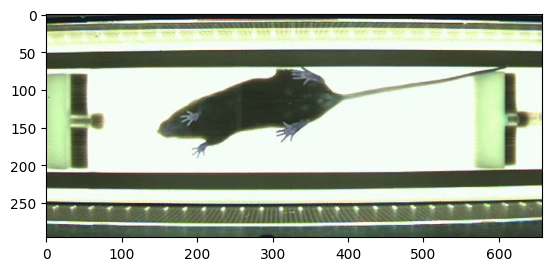

In [12]:
test_image_path = os.path.join(working_dir, test_img_selection.value)
img = cv2.imread(test_image_path)
plt.imshow(img)

In [18]:
# Modeling settings
model_types = ["pytorch", "onnx"]
devices = ["cpu", "cuda", "tensorrt"]

modeltype_selection = widgets.Dropdown(
    options=model_types,
    value=model_types[0],
    description="ModelType",
    disabled=False,
)
device_selection = widgets.Dropdown(
    options=devices,
    value=devices[0],
    description="Device",
    disabled=False,
)
model_precision = widgets.RadioButtons(options=["FP32", "FP16"], description="Precision")
display(modeltype_selection, device_selection, model_precision)

Dropdown(description='ModelType', options=('pytorch', 'onnx'), value='pytorch')

Dropdown(description='Device', options=('cpu', 'cuda', 'tensorrt'), value='cpu')

RadioButtons(description='Precision', options=('FP32', 'FP16'), value='FP32')

In [27]:
def get_model_size(model_path):
    """
    Calculates the size of an ONNX model in bytes.

    Args:
        model_path (str): The path to the ONNX model file.

    Returns:
        int: The size of the model in bytes.
    """
    if ".onnx" in model_path:
        model = onnx.load(model_path)
        size_bytes = len(model.SerializeToString())
    elif ".pt" in model_path:
        model = torch.load(model_path)
        params = list(model.parameters())
        size_bytes = sum([p.numel() * p.element_size() for p in params])

    # Convert to KB, MB, GB, etc.
    if size_bytes < 1024:
        size_str = f"{size_bytes} B"
    elif size_bytes < 1024 * 1024:
        size_str = f"{size_bytes / 1024:.2f} KB"
    elif size_bytes < 1024 * 1024 * 1024:
        size_str = f"{size_bytes / (1024 * 1024):.2f} MB"
    else:
        size_str = f"{size_bytes / (1024 * 1024 * 1024):.2f} GB"

    return size_str

In [29]:
get_model_size(onnx_fp16_model_path)

'46.16 MB'

In [19]:
display_choice = widgets.RadioButtons(description="Display?", options=["True", "False"])
display(display_choice)

RadioButtons(description='Display?', options=('True', 'False'), value='True')

In [20]:
# Display settings
#* Replace the following with your display settings
resize_ratio = 0.7
# cropping = [50, 250, 100, 450]
# dynamic_cropping = (True, 0.5, 10)

In [86]:
dlc_live = DLCLive(
    path=working_dir,
    model_type=modeltype_selection.value,
    device=device_selection.value,
    display=bool(display_choice.value),
    snapshot=snapshot_selection.value,
    resize=resize_ratio,
    # cropping=cropping,
    # dynamic=dynamic_cropping
    precision=model_precision.value,
)

onnx_pose = dlc_live.init_inference(frame=img)
onnx_pose

Loading the model took 6.0490076541900635 sec
ONNX inference took 57.3887243270874 sec
ONNX postprocessing took 0.0012662410736083984 sec


({'poses': tensor([[[[153.4859, 163.0584,   0.9390],
            [146.2037, 159.6940,   0.9385],
            [150.2816, 149.5908,   0.8623],
            [196.7652, 135.4481,   0.8379],
            [205.9059, 174.2914,   0.8442],
            [344.7755,  81.8269,   0.5615],
            [325.0722, 150.6396,   0.8486],
            [247.0956, 108.0074,   0.9775],
            [255.2765, 130.1171,   0.8516],
            [253.8192, 153.2904,   0.8735],
            [381.4149, 111.1283,   0.7905]]]])},
 57.3887243270874)

In [78]:
dlc_live.display.destroy()

### Video inference

In [21]:
test_videos = glob.glob(os.path.normpath(working_dir + "/*.avi"))
test_videos.extend(glob.glob(os.path.normpath(working_dir + "/*.mp4")))
test_videos = [t.split("/")[-1] for t in test_videos]

test_vid_selection = widgets.Dropdown(
    options=test_videos,
    value=test_videos[0],
    description="Test Video!",
    disabled=False,
)
display(test_vid_selection)

Dropdown(description='Test Video!', options=('1_20cms_0degUP_first.avi', '1_20cms_0degUP_first_1s.avi', '1_20c…

In [41]:
def get_video_characteristics(video_path):
    """
    Extracts the FPS, number of frames, length in seconds, and frame size of a video.

    Args:
        video_path (str): The path to the video file.

    Returns:
        tuple: A tuple containing the FPS, number of frames, length in seconds, and frame size.
    """

    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) * 0.25
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) * 0.25

    # Calculate video length in seconds
    video_length = frame_count / fps

    cap.release()

    return fps, frame_count, video_length, (frame_width, frame_height)

In [42]:
video_path = os.path.join(working_dir, test_vid_selection.value)

fps, frame_count, video_length, frame_size = get_video_characteristics(video_path)

print("FPS:", fps)
print("Number of frames:", frame_count)
print("Video length (seconds):", video_length)
print("Frame size:", frame_size)

FPS: 150.0
Number of frames: 150.0
Video length (seconds): 1.0
Frame size: (164.5, 75.5)


In [22]:
save_video_choice = widgets.RadioButtons(options=["True", "False"], description="Save processed video?")
display(save_video_choice)

RadioButtons(description='Save processed video?', options=('True', 'False'), value='True')

In [28]:
if save_video_choice.value == 'False': save_video = False
else: save_video = True

In [38]:
poses, times = analyze_video(
    video_path=video_path,
    model_type=modeltype_selection.value,
    snapshot=snapshot_selection.value,
    device=device_selection.value,
    resize=resize_ratio,
    # cropping=cropping,
    # dynamic=dynamic_cropping
    precision=model_precision.value,
    model_path=working_dir,
    display=True,
    save_poses=True,
    save_dir=working_dir + "/out",
    draw_keypoint_names=False,
    save_video=save_video
)

False
{'host_name': 'dikra', 'op_sys': 'Linux-6.8.0-41-generic-x86_64-with-glibc2.39', 'python': 'dlc-live', 'device_type': 'GPU', 'device': ['NVIDIA GeForce RTX 3050 6GB Laptop GPU'], 'freeze': ['albumentations==1.4.3', 'anyio==4.4.0', 'argon2-cffi==23.1.0', 'argon2-cffi-bindings==21.2.0', 'arrow==1.3.0', 'asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1698341106958/work', 'async-lru==2.0.4', 'attrs==24.2.0', 'autocommand==2.2.2', 'babel==2.16.0', 'backports.tarfile==1.2.0', 'beautifulsoup4==4.12.3', 'black==24.8.0', 'bleach==6.1.0', 'blosc2==2.0.0', 'certifi==2024.7.4', 'cffi==1.17.0', 'charset-normalizer==3.3.2', 'click==8.1.7', 'colorcet==3.1.0', 'coloredlogs==15.0.1', 'comm @ file:///home/conda/feedstock_root/build_artifacts/comm_1710320294760/work', 'contourpy==1.2.1', 'cycler==0.12.1', 'Cython==3.0.11', 'debugpy @ file:///croot/debugpy_1690905042057/work', 'decorator @ file:///home/conda/feedstock_root/build_artifacts/decorator_1641555617451/work', '-e g

### Profiling

In [54]:
# Compute mean ± std inference time per frame
print(
    "Mean inference time including 1st inference ",
    np.round(np.mean(times) * 1000, 2),
    "ms ±",
    np.round(np.std(times) * 1000, 2),
)
print(
    "Mean inference time excluding 1st inference ",
    np.round(np.mean(times[1:]) * 1000, 2),
    "ms ±",
    np.round(np.std(times[1:]) * 1000, 2),
)

Mean inference time including 1st inference  17.17 ms ± 81.67
Mean inference time excluding 1st inference  10.49 ms ± 2.66


In [46]:
def calculate_fps_stats(inference_times):
    """
    Calculates the average FPS rate and its standard deviation from a list of inference times.

    Args:
        inference_times (list): A list of inference times in seconds.

    Returns:
        tuple: A tuple containing the average FPS rate and its standard deviation.
    """

    # Calculate FPS for each frame
    fps_values = [1 / time for time in inference_times]

    # Calculate average FPS
    average_fps = np.mean(fps_values)

    # Calculate standard deviation of FPS
    std_dev_fps = np.std(fps_values)

    return average_fps, std_dev_fps

In [53]:
average_fps, std_dev_fps = calculate_fps_stats(times)

print("Average FPS:", np.round(average_fps, 2))
print("Standard Deviation of FPS:", np.round(std_dev_fps, 2))

Average FPS: 99.35
Standard Deviation of FPS: 20.34


### Live video inference (todo)